# <center>Image Compression with ICA+KMeans</center> #

### <center>Alex Blaine & David Haley</center> ###



The goal of our project is to augment Independent Component Analysis with KMeans in order to compress images.  We first take a training set of images (most are animals in a natural setting) and use this to train the ICA algorithm so that it creates a sufficient basis.  Then we use KMeans to reduce the number of unique intensities of the basis vectors in order to provide even more compression, and compare the results to the original image.

In [1]:
from readImages import readAll
images = readAll('Natural_Images/Resized', '.png')

First let's take a look at the original test image.

We only need a single test image as the number of samples from compressing a single image is roughly a $\frac{1}{4}$ holdout.

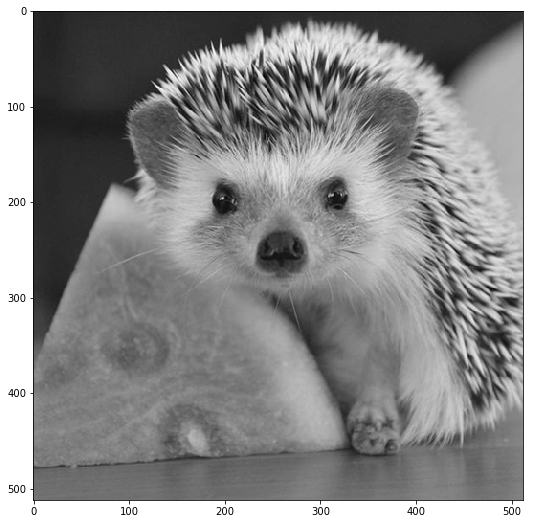

In [2]:
import matplotlib.pyplot as plt
from scipy import misc
%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 9]

train = images[:5] + images[6:]
test = images[5]

plt.imshow(test, cmap='gray')
plt.show()

Now, we'll use 1600 randomly sampled blocks from the remaining 10 images to find an ICA basis.

We're using the Scikit Learn implementation of FastICA to accomplish this.

In [3]:
from ICA import train_ICA, ICA_decompose
block_size = 8

basis, train, px, py = train_ICA(train, block_size, num_samples=1600)

This creates a basis of 8x8 blocks which are displayed below.

It's clear some of these basis vectors approximate features.

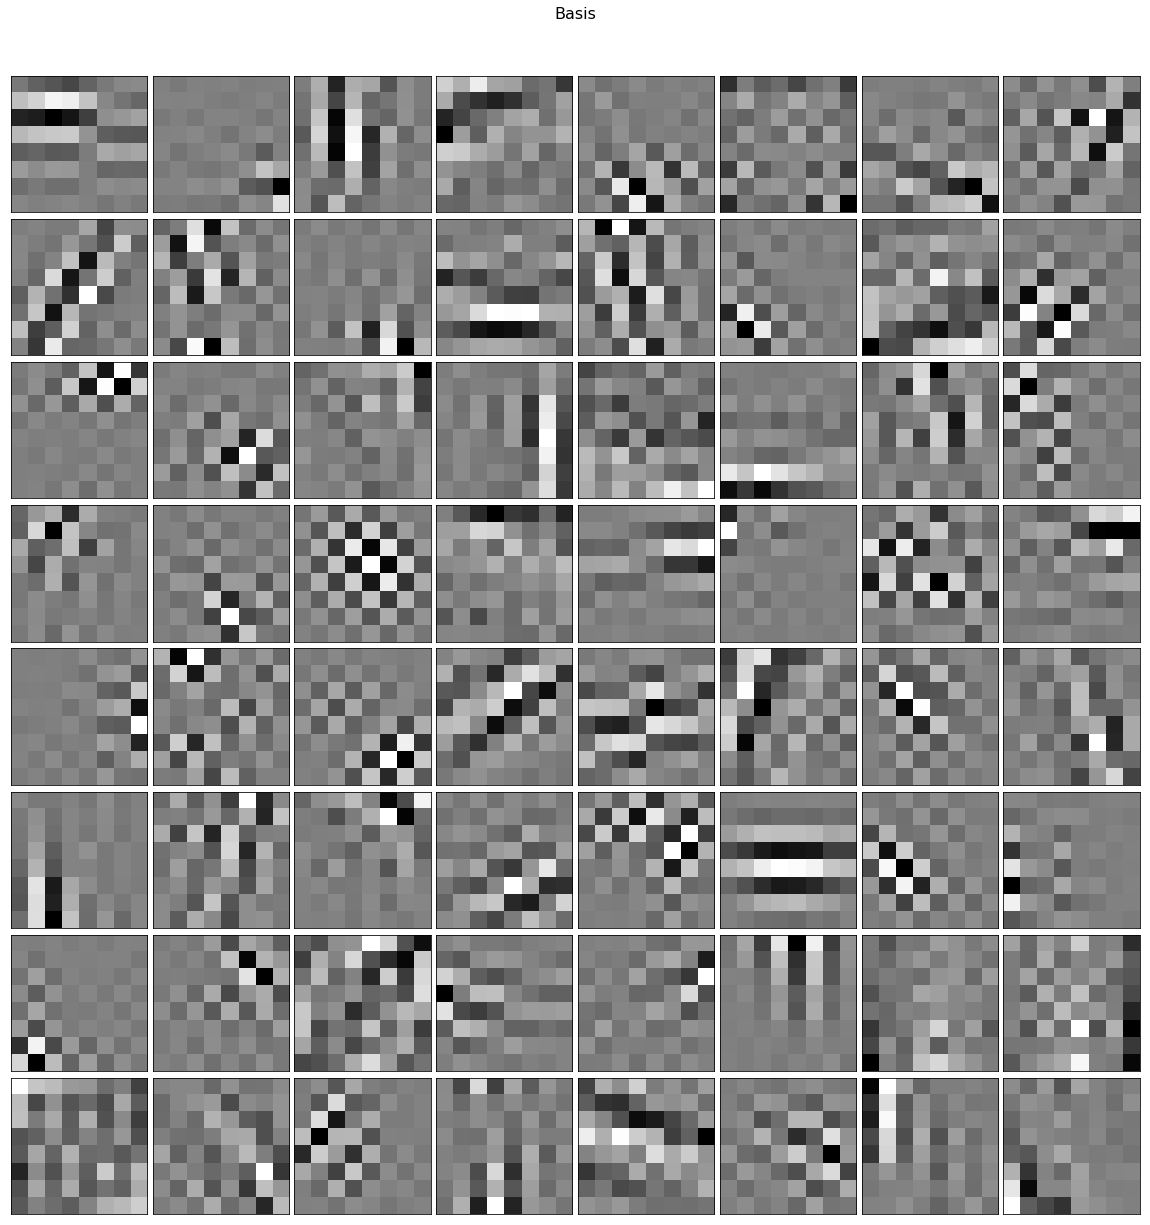

In [139]:
from ICA import plot_gallery
plot_gallery('Basis', basis, n_col=8, n_row=8, image_shape=(block_size,block_size))

Now, we can use Scikit Learn's Orthogonal Matching Pursuit to decompose our test image.

We'll use a low tolerance here to show we can accurately reconstruct images using our method before compressing them.

In [143]:
decomposition, intercept, iterations = ICA_decompose(test, block_size, basis, 1)

We take a quick look at the reconstructed image

In [144]:
from ICA import reconstruct
reconstructed_image = reconstruct(decomposition, intercept, basis, block_size, images[3].shape)

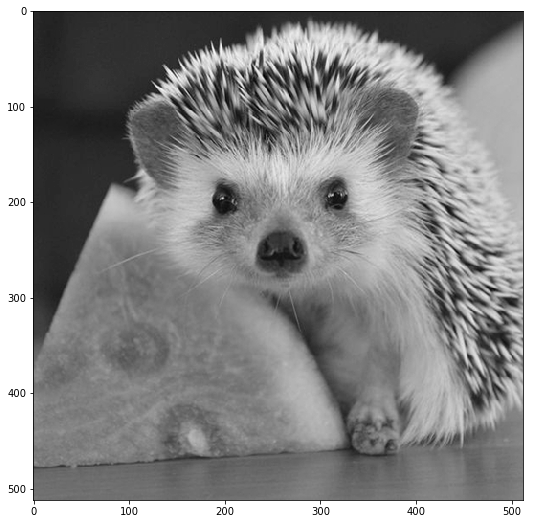

In [146]:
import numpy as np
plt.imshow(reconstructed_image, cmap='gray')
plt.show()

Now, we convert the dense matrix of coefficients for each block to a sparse form, Scipy's Compressed Sparse Row form.

In [147]:
from scipy.sparse import lil_matrix
block_coeff = []
for dec in decomposition:
    block_coeff.append(dec)
    
block_coeff_sparse = lil_matrix(block_coeff)
bccsr = block_coeff_sparse.tocsr()

With the image now sparsified using ICA, we can further compress the image by using KMeans to reduce the number of unique values that we use as coefficients for the basis vectors.

In [104]:
from sklearn.cluster import KMeans

The next two blocks first compress the ambient (average) colors for the blocks by forcing them to take on one of 256 values, found by KMeans.

In [155]:
#"near perfect" reconstruction with 256 colors
#seems to do "very good" with just 64 colors
#seems to do "good" with 32 colors
#experiment with setting this to 16, it does "pretty good"
n_colors = 256

int_shaped = intercept.reshape(-1,1)       #force 1D array into k-means
kmeans_int = KMeans(n_clusters=n_colors,n_jobs=-1).fit(int_shaped)

In [156]:
#the following 2 data structures will contain the lookup table for colors and the table indices, respectively
# so they are the only things needed to reconstruct the array "intercept"
intercept_lookup = np.ravel(kmeans_int.cluster_centers_)     #contains the lookup table of the floating point color numbers
intercept_compressed = kmeans_int.predict(int_shaped)        #contains numbers from [0..n_colors-1]

#reconstruct intercept in order to display the results after compression
intercept_km = np.array([intercept_lookup[index] for index in intercept_compressed])

We perform a similar compression for the coefficients of the ICA basis, so that these coefficients can only take on one of 256 unique values.

In [157]:
from scipy.sparse import *

#can uncomment the next line to use a different number of colors from the intercept
#n_colors = 64

bccsr_shaped = bccsr.data.reshape(-1,1)              #only using the nonzero values of our sparse matrix

#patience -- this takes a while (a couple minutes for 256 colors on 4096 blocks)
kmeans_dec = KMeans(n_clusters=n_colors,n_jobs=-1).fit(bccsr_shaped)

In [158]:
#the following 3 data structures will contain the lookup table for colors and the table indices, respectively
# so they are the only things needed to reconstruct the array "decomposition"
bccsr_indices = bccsr.nonzero()                             #contains the sparse matrix indices
bccsr_lookup = np.ravel(kmeans_dec.cluster_centers_)        #contains the lookup table of the floating point color numbers
bccsr_compressed = kmeans_dec.predict(bccsr_shaped)         #contains numbers from [0..n_colors-1]

#reconstruct intercept in order to display the results after compression
bccsr_values = [bccsr_lookup[index] for index in bccsr_compressed]
bccsr_km = csr_matrix((bccsr_values, (bccsr_indices[0],bccsr_indices[1]))).toarray()

After compressing the number of coefficients using KMeans, we now reconstruct the image again.

The reconstruction below is faithful to the original image, but this is to be expected since we are not compressing the image much (yet).

In [159]:
reconstructed_image = reconstruct(bccsr_km, intercept_km, basis, block_size, test.shape)

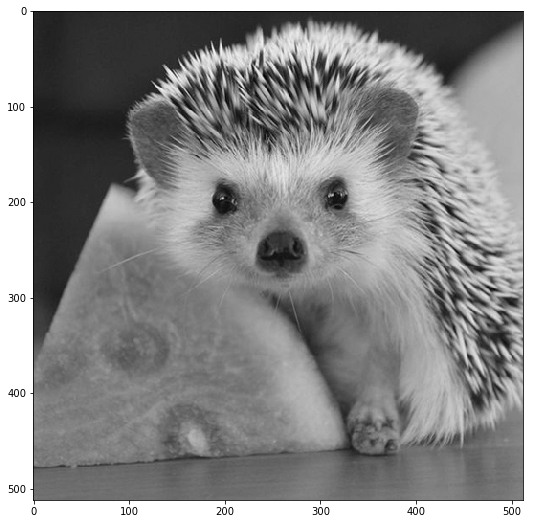

In [160]:
import numpy as np
plt.imshow(reconstructed_image, cmap='gray')
plt.show()

In [161]:
compressed_size = len(bccsr_indices) * 32 + len(bccsr_compressed) * 8 + len(bccsr_lookup) * 32 \
+ len(intercept_lookup) * 32 + len(intercept_compressed) * 8
print('Compression ratio: %.3f' % (1.*(test.nbytes)/(compressed_size)))
print('Bits per pixel: %.3f'% (1.*(compressed_size)/(512 ** 2)))

Compression ratio: 1.117
Bits per pixel: 7.162


Now, we're going to generate a gallery of compressed images by using a grid of tolerances and number of colors.

Left to right is decreasing number of colors (KMeans centers), top to bottom is increasing tolerance (for the ICA basis).

In [131]:
from math import log

In [133]:
Tols = [50, 500, 5000]
Colors = [256, 64, 16]
sizes = []
reconstructed_images = []

for tol in Tols: #Takes forever, generates reconstructed test images for different tolerances and number of colors
    decomposition, intercept, iterations = ICA_decompose(test, block_size, basis, tol)
    block_coeff = []
    for dec in decomposition:
        block_coeff.append(dec)
    
    block_coeff_sparse = lil_matrix(block_coeff)
    bccsr = block_coeff_sparse.tocsr()
    for colors in Colors:
        n_colors = colors

        int_shaped = intercept.reshape(-1,1)
        kmeans_int = KMeans(n_clusters=n_colors,n_jobs=-1).fit(int_shaped)
        intercept_lookup = np.ravel(kmeans_int.cluster_centers_)     
        intercept_compressed = kmeans_int.predict(int_shaped)        

        intercept_km = np.array([intercept_lookup[index] for index in intercept_compressed])
        bccsr_shaped = bccsr.data.reshape(-1,1)

        kmeans_dec = KMeans(n_clusters=n_colors,n_jobs=-1).fit(bccsr_shaped)
        bccsr_indices = bccsr.nonzero()                         
        bccsr_lookup = np.ravel(kmeans_dec.cluster_centers_)        
        bccsr_compressed = kmeans_dec.predict(bccsr_shaped)         

        bccsr_values = [bccsr_lookup[index] for index in bccsr_compressed]
        bccsr_km = csr_matrix((bccsr_values, (bccsr_indices[0],bccsr_indices[1]))).toarray()
        n_color_bits = log(n_colors, 2)
        compressed_size = len(bccsr_indices) * 24 + len(bccsr_compressed) * n_color_bits + len(bccsr_lookup) * 32 \
                     + len(intercept_lookup) * 32 + len(intercept_compressed) * n_color_bits
        sizes.append(compressed_size)
        reconstructed_images.append(reconstruct(bccsr_km, intercept_km, basis, block_size, test.shape))

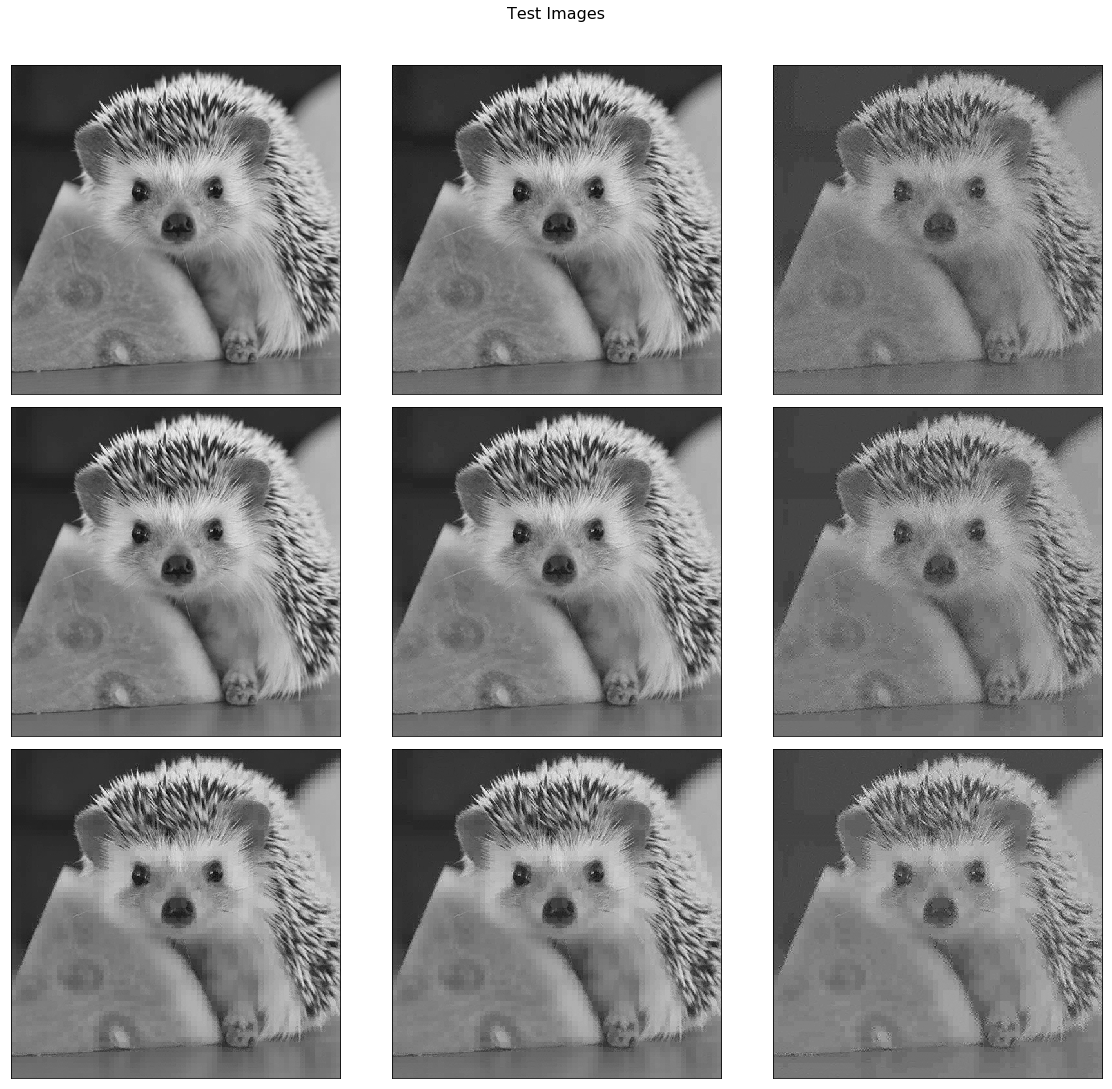

In [134]:
plt.figure(figsize=(16, 16))
plt.suptitle('Test Images', size=16)
for i, comp in enumerate(reconstructed_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(comp.reshape(test.shape), cmap='gray')
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.04)
plt.show()

Notably, placing more strain on the ICA algorithm produces a "blockiness" which begins to appear noticably in the hardwood flooring underneath the hedgehog.  This is likely the first noticable artifact since the training set largely contains images of animals in their natural settings, and the glossiness of the hardwood surface is not well represented in the training set.

Placing more strain on the KMeans algorithm produces a granularity in the image that could be due to the increasing mismatch of colors along the borders of the blocks, as well as disallowing small nozero coefficients that would otherwise "smooth" out areas that do not sharply transition in color.

Now, we'll look at the compression ratio and bits per pixel for each of these images.

In [162]:
ratios = []
bpps = []
for size in sizes:
    ratios.append(1.*(test.nbytes)/(size))
    bpps.append(1.*(size)/(512 ** 2))

ratios = np.reshape(ratios,(3,3),'C')
bpps = np.reshape(bpps,(3,3),'C')
print('Compression ratios: ')
print(ratios)
print('Bits per pixel: ')
print(bpps)

Compression ratios: 
[[  1.64134416   2.20730072   3.31981232]
 [  2.82227294   3.8190864    5.75520868]
 [  6.48823107   8.95308191  13.57661134]]
Bits per pixel: 
[[ 4.87405396  3.62433624  2.40977478]
 [ 2.83459473  2.09474182  1.39004517]
 [ 1.23300171  0.89354706  0.58924866]]


Even down to under 0.6 bits per pixel we can clearly distinguish most of the features of the original image.